IMPORTS

In [1]:
import pandas as pd
import numpy as np
import os 
import shutil

import splitfolders
from imutils import paths
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from PIL import Image
from collections import Counter
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.models as models
import torch.nn.functional as f
import torch.nn as nn
import torch.optim as optim
import Augmentor
from torchmetrics import Accuracy


DATA SEPARATION

In [3]:
#Data collection -> spliting sets and putting images into proper directories
df_train_framefilter = pd.read_csv('df_train_framefilter.csv')
train_labels = df_train_framefilter['category']
X_train_paths = df_train_framefilter['basename']
# Creating subdirectories named after particular labels
classes = np.unique(train_labels)
if not os.path.isdir('train_data'):
    os.mkdir('train_data')
for class_ in classes:
    path = f'train_data/{class_}'
    if not os.path.isdir(path):
        os.mkdir(path)


In [ ]:
#Changing files path to put them into proper directories
[shutil.move(f'train/{path}', f'train_data/{label}/{path}') for path, label in zip(X_train_paths, train_labels)];

In [4]:
print(classes)

['aerial_view' 'closeup' 'front_view' 'non_match' 'side_gate_view'
 'side_view' 'wide_view']


In order to deal with an imbalanced class problem I decided to create augmented photos to provide additional samples. There were created 5000 images for each class

In [5]:
for cla in classes:
    p = Augmentor.Pipeline(f'train_data/{cla}/')
    p.rotate(probability=0.8, max_left_rotation=15, max_right_rotation=15)
    p.flip_left_right(probability=0.8)
    
    p.shear(probability=0.8, max_shear_left=20, max_shear_right=20)
    p.sample(5000, multi_threaded=True)


Initialised with 67 image(s) found.
Output directory set to train_data/aerial_view/output.

Processing <PIL.Image.Image image mode=RGB size=1280x720 at 0x7F3B880A8550>: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:47<00:00,  7.72 Samples/s]


Initialised with 2812 image(s) found.
Output directory set to train_data/closeup/output.

Processing <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F3BCA799790>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:40<00:00,  9.60 Samples/s]


Initialised with 114 image(s) found.
Output directory set to train_data/front_view/output.

Processing <PIL.Image.Image image mode=RGB size=3840x2160 at 0x7F3BC81705B0>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:44<00:00,  7.76 Samples/s]


Initialised with 1638 image(s) found.
Output directory set to train_data/non_match/output.

Processing <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F3BC8272700>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [07:51<00:00, 10.60 Samples/s]


Initialised with 109 image(s) found.
Output directory set to train_data/side_gate_view/output.

Processing <PIL.Image.Image image mode=RGB size=3840x2160 at 0x7F3BC81BC5E0>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:57<00:00,  7.61 Samples/s]


Initialised with 6200 image(s) found.
Output directory set to train_data/side_view/output.

Processing <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F3BB5504610>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:32<00:00,  9.76 Samples/s]


Initialised with 47 image(s) found.
Output directory set to train_data/wide_view/output.

Processing <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F3BB7766FA0>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [09:57<00:00,  8.36 Samples/s]


CONFIGURATION SETUP

In [2]:
#device config
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model configs
EPOCHS = 15
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 4
LR = 0.003
MODEL_PATH = 'best-model.pt'
#transform configs
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 128
#Building train/val ds configs
SPLIT_RATIO = 0.2
INPUT_DIR = 'train_data'
OUTPUT_DIR = 'DATASET'
TRAIN = os.path.join(OUTPUT_DIR + '/train')
VAL = os.path.join(OUTPUT_DIR + '/val')

DATASET SPLIT

In [7]:

splitfolders.ratio(input=INPUT_DIR, output=OUTPUT_DIR, seed=42, ratio=(.8, .2), group_prefix=None)

Copying files: 35000 files [00:45, 768.51 files/s] 


In [3]:
transforms_dict = {'train':transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomRotation(15),                                               
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=MEAN, std=STD)]),
                  'val':transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=MEAN, std=STD)])}

In [4]:
def ds_and_loader(phase, transforms_dict, weights=None):
    if phase == 'train':
        ds = ImageFolder(TRAIN, transform=transforms_dict[phase])
        if weights:
            train_classes = [label for _, label in tqdm(ds)]
            class_count = Counter(train_classes)
            class_weights = torch.Tensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values])
            sample_weights = [0] * len(ds)
            for idx, (imagle, label) in tqdm(enumerate(ds)):
                class_weight = class_weights[label]
                sample_weights[idx] = class_weight
            sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(ds),
                                           replacement = True)
                
            loader = DataLoader(ds, batch_size=TRAIN_BATCH_SIZE, sampler=sampler,
                            num_workers=os.cpu_count(), 
                            pin_memory=True if DEVICE == "cuda" else False )
        else:
            loader = DataLoader(ds, batch_size=TRAIN_BATCH_SIZE, shuffle = True,
                               num_workers=os.cpu_count(),
                               pin_memory=True if DEVICE == "cuda" else False)
    elif phase == 'val':
        ds = ImageFolder(VAL, transform=transforms_dict[phase])
        loader = DataLoader(ds, batch_size=VAL_BATCH_SIZE,shuffle=False,
                           num_workers=os.cpu_count(),
                           pin_memory=True if DEVICE == 'cuda' else False)
    else:
        raise 'Wrong phase: Either choose train or val'
    return ds, loader
    

In [5]:
#Callbacks
class EarlyStopping:
  def __init__(self, patience=5, path=MODEL_PATH):
    self.patience = patience
    self.path= path
    self.counter = 0
    self.best_score = None
    self.early_stop = False

  def __call__(self, val_loss, model):
    if self.best_score is None:
      self.best_score = val_loss
      self.save_checkpoint(model)
    elif val_loss > self.best_score:
      self.counter +=1
      if self.counter >= self.patience:
        self.early_stop = True 
    else:
      self.best_score = val_loss
      self.save_checkpoint(model)
      self.counter = 0      

  def save_checkpoint(self, model):
    torch.save(model.state_dict(), self.path)

In [12]:
class FootballImage():
    def __init__(self, num_classes, device, train_ds, loss_weights=False,
     lr=LR, stop_early=True, freeze_backbone=True):        
        self.num_classes = num_classes
        self.device = device
        self.loss_weights = loss_weights
        self.lr = lr
        self.stop_early = stop_early
        self.freeze_backbone = freeze_backbone
        self.train_ds = train_ds
    
    
    def load_model(self):  
        self.model = models.resnet50(pretrained=True)
        self.fc_inputs = self.model.fc.in_features
        if self.freeze_backbone:
            for param in self.model.parameters():
                param.requires_grad = False
        
        self.model.fc = nn.Linear(in_features=self.fc_inputs, out_features=self.num_classes)
        self.model = self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr) 

        
        if self.loss_weights:
            train_classes = [label for _, label in tqdm(self.train_ds)]
            class_count = Counter(self.train_classes)
            class_weights = torch.Tensor([len(self.train_classes)/c for c in pd.Series(class_count).sort_index().values])
            
            class_weights = class_weights.to(self.device)  
            self.criterion = nn.CrossEntropyLoss(class_weights)
        else:
            self.criterion = nn.CrossEntropyLoss()
    
    def fit_one_epoch(self, train_loader, epoch, num_epochs ): 
        step_train = 0

        train_losses = list() 
       
        self.model.train()
        accuracy = Accuracy()
        acc_lst = []
        for i, (images, targets) in enumerate(tqdm(train_loader)):
            images = images.to(self.device)
            targets = targets.to(self.device)
            #forward
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
            
            loss.backward()
            self.optimizer.step()

            self.optimizer.zero_grad()
            preds_acc = accuracy(outputs.to('cpu'), targets.to('cpu'))

            train_losses.append(loss.item())
            acc_lst.append(preds_acc.item())

        acc = torch.tensor(acc_lst).mean()    
        train_loss = torch.tensor(train_losses).mean()    
        print(f'Epoch {epoch}/{num_epochs-1}')  
        print(f'Training loss: {train_loss:.2f}')
        print(f'Training accuracy: {acc:.3f}')
        
    def val_one_epoch(self, val_loader):
        val_losses = list()
        
        val_acc = list()
        self.model.eval()
        step_val = 0
        accuracy = Accuracy()
        with torch.no_grad():
            for (images, targets) in val_loader:
                images = images.to(self.device)
                targets = targets.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                val_pred_acc = accuracy(outputs.to('cpu'), targets.to('cpu'))
                val_acc.append(val_pred_acc.item())
                val_losses.append(loss.item())
                   
            acc = torch.tensor(val_acc).mean()
            self.val_loss = torch.tensor(val_losses).mean()
            print(f'Validation loss: {self.val_loss:.2f}')  
            print(f'Validation accuracy: {acc:.2f}')
            
    def fit(self, train_loader, val_loader, num_epochs=10, unfreeze_after=5, checkpoint_dir=MODEL_PATH):
        if self.stop_early: #to prevent from overfitting
            early_stopping = EarlyStopping(
            patience=5, 
            path=checkpoint_dir)

        for epoch in range(num_epochs):
            if self.freeze_backbone:
                if epoch == unfreeze_after:  # Unfreeze after x epochs
                    for param in self.model.parameters():
                        param.requires_grad = True
            self.fit_one_epoch(train_loader, epoch, num_epochs)
            self.val_one_epoch(val_loader)
            if self.stop_early:
                early_stopping(self.val_loss, self.model)
                if early_stopping.early_stop:
                    print('Early Stopping')
                    print(f'Best validation loss: {early_stopping.best_score}')
                    break







In [13]:
ds,train_loader = ds_and_loader('train', transforms_dict, False)
_,val_loader = ds_and_loader('val', transforms_dict, False)

In [14]:
model = FootballImage(num_classes=7, device=DEVICE,train_ds = ds, loss_weights=False)                             
model.load_model()
model.fit(num_epochs=EPOCHS, unfreeze_after=2, train_loader=train_loader, val_loader=val_loader)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:16<00:00,  6.82it/s]

Epoch 0/14
Training loss: 1.15
Training accuracy: 0.619


Validation loss: 1.01
Validation accuracy: 0.69


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:13<00:00,  6.90it/s]

Epoch 1/14
Training loss: 1.06
Training accuracy: 0.669


Validation loss: 0.91
Validation accuracy: 0.71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:39<00:00,  6.26it/s]

Epoch 2/14
Training loss: 1.45
Training accuracy: 0.474


Validation loss: 1.30
Validation accuracy: 0.56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:54<00:00,  5.94it/s]


Epoch 3/14
Training loss: 0.97
Training accuracy: 0.632
Validation loss: 0.77
Validation accuracy: 0.70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:46<00:00,  6.11it/s]

Epoch 4/14
Training loss: 0.77
Training accuracy: 0.702


Validation loss: 0.76
Validation accuracy: 0.71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:53<00:00,  5.97it/s]

Epoch 5/14
Training loss: 0.61
Training accuracy: 0.763


Validation loss: 0.49
Validation accuracy: 0.81


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:54<00:00,  5.94it/s]

Epoch 6/14
Training loss: 0.51
Training accuracy: 0.802


Validation loss: 0.58
Validation accuracy: 0.79


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:45<00:00,  6.12it/s]

Epoch 7/14
Training loss: 0.43
Training accuracy: 0.833


Validation loss: 0.39
Validation accuracy: 0.85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:43<00:00,  6.18it/s]

Epoch 8/14
Training loss: 0.37
Training accuracy: 0.858


Validation loss: 0.41
Validation accuracy: 0.85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:38<00:00,  6.28it/s]

Epoch 9/14
Training loss: 0.33
Training accuracy: 0.873


Validation loss: 0.30
Validation accuracy: 0.88


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:38<00:00,  6.27it/s]

Epoch 10/14
Training loss: 0.30
Training accuracy: 0.883


Validation loss: 0.30
Validation accuracy: 0.88


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:39<00:00,  6.25it/s]

Epoch 11/14
Training loss: 0.26
Training accuracy: 0.896


Validation loss: 0.25
Validation accuracy: 0.90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:44<00:00,  6.16it/s]

Epoch 12/14
Training loss: 0.24
Training accuracy: 0.908


Validation loss: 0.25
Validation accuracy: 0.90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:40<00:00,  6.23it/s]

Epoch 13/14
Training loss: 0.22
Training accuracy: 0.912


Validation loss: 0.22
Validation accuracy: 0.92


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [04:42<00:00,  6.19it/s]

Epoch 14/14
Training loss: 0.21
Training accuracy: 0.921


Validation loss: 0.21
Validation accuracy: 0.92


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


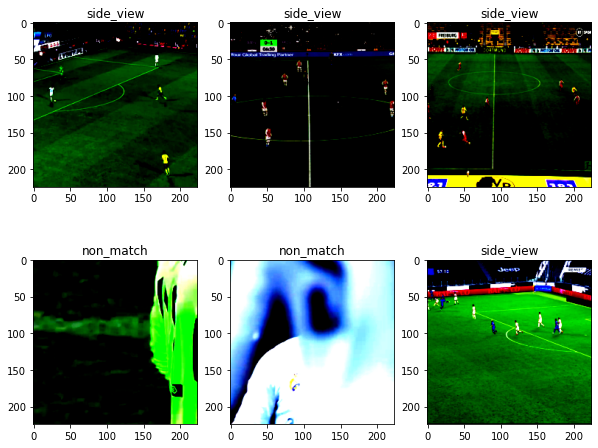

In [33]:
#Preview of transformed images

img_batch, lbl = next(iter(train_loader))
plt.subplots(figsize = (10,8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(img_batch[i].permute(1, 2, 0))
    plt.title(train_set.classes[lbl[i].item()])
plt.show()    

In [16]:
#Time for prediction and final words
#Call saved model
model = torchvision.models.resnet50()
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=7)
model = model.to(device)
checkpoint = torch.load('./checkpoint.pt')
model.load_state_dict(checkpoint)
model.eval()


# custom dataset class for a test data
class FootbalTest(Dataset):
  def __init__(self, dir, transform=None):
    self.dir = dir
    self.transform = transform

    self.images = os.listdir(self.dir)  

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = Image.open(os.path.join(self.dir, self.images[idx]))
    return self.transform(img), self.images[idx] 


test_dir = './test'
test_set = FootbalTest(test_dir, transform=Transform)
test_loader = DataLoader(test_set, batch_size=1)  

# Test loop
submision = pd.DataFrame(columns=['basename', 'class','probability'])
basename_list = []
label_list = []
probability_list = []

model = model.to(device)

with torch.no_grad():
  for (image, image_id) in tqdm(test_loader):
    image = image.to(device)

    output = model(image)
    predicted = list(torch.argmax(output, 1).cpu().numpy())
    prob = f.softmax(output, dim=1)

    top_p, top_class = prob.topk(1, dim = 1)
    
    probability_list.append(top_p)

    for basename in image_id:        
        basename_list.append(basename)
  
    for prediction in predicted:        
        label_list.append(prediction)

train_full_2 = ImageFolder('./train_data', transform=Transform)
label_names = train_full_2.class_to_idx
print(label_names)
legend = {0:'aerial_view', 1:'closeup', 2:'front_view', 3:'non_match',
          4:'side_gate_view', 5:'side_view', 6:'wide_view'}

submision['basename'] = id_list
submision['class'] = [legend[value] for value in label_list] 
submision['probability'] = [round(float(prob),4) for prob in probability_list]
#since df_train_framefilter was sorted, my predections will be also sorted
submission = submision.sort_values('basename')
#submission --> .csv file
submission.to_csv('Predictions_submission.csv',index=False)

    





100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3117/3117 [03:23<00:00, 15.34it/s]


['b4f1523e2bfaff6bc8255c7a-00000304.jpg', '90c905f36a563aa439d0d8e8-00013896.jpg', '7cdcd35affc8cc427e3275fd-00105977.jpg', '290d949f97ff2fda835b04c2-00066596.jpg', '255b60c3140b40de262ec5d9-00092640.jpg', '290d949f97ff2fda835b04c2-00132422.jpg', '7eb577ba9dfd9f2d443fd5b8-00002906.jpg', 'a8e3e932fbbf559844e2d2ee-00007646.jpg', '41dc3984c8bf2f3572506ac3-00132951.jpg', '1597dcc14be8bd5860efbd2b-00130382.jpg', '8c3e424b2c088ec0ce5faad7-00053945.jpg', '6862d5dde2217d22da16dee5-00002550.jpg', '1e2251a894690ac79324b119-00128266.jpg', '1597dcc14be8bd5860efbd2b-00037803.jpg', '1597dcc14be8bd5860efbd2b-00036704.jpg', '03f0445b7080dba483ca45a7-00001572.jpg', '5f40487e05bd3e7c70e4eb94-00082201.jpg', '1e2251a894690ac79324b119-00033494.jpg', '7cdcd35affc8cc427e3275fd-00120363.jpg', 'a8e3e932fbbf559844e2d2ee-00073918.jpg', 'e136be7e1b771b73501c41b1-00050974.jpg', 'e136be7e1b771b73501c41b1-00060371.jpg', '8cba2c596ac9d64911f32de8-00001023.jpg', '5e61fa41d258f0da81afd18d-00063204.jpg', 'fc5377692859c6

[tensor([[0.9993]], device='cuda:0'), tensor([[0.9998]], device='cuda:0'), tensor([[0.5008]], device='cuda:0'), tensor([[0.9943]], device='cuda:0'), tensor([[0.8214]], device='cuda:0'), tensor([[0.9989]], device='cuda:0'), tensor([[0.9092]], device='cuda:0'), tensor([[0.9988]], device='cuda:0'), tensor([[0.9397]], device='cuda:0'), tensor([[0.9933]], device='cuda:0'), tensor([[0.9972]], device='cuda:0'), tensor([[0.9095]], device='cuda:0'), tensor([[0.9996]], device='cuda:0'), tensor([[0.9991]], device='cuda:0'), tensor([[0.9986]], device='cuda:0'), tensor([[0.9928]], device='cuda:0'), tensor([[0.9989]], device='cuda:0'), tensor([[0.9954]], device='cuda:0'), tensor([[0.3767]], device='cuda:0'), tensor([[0.9975]], device='cuda:0'), tensor([[0.9931]], device='cuda:0'), tensor([[0.6193]], device='cuda:0'), tensor([[0.5097]], device='cuda:0'), tensor([[0.9845]], device='cuda:0'), tensor([[0.5943]], device='cuda:0'), tensor([[0.9999]], device='cuda:0'), tensor([[0.9996]], device='cuda:0'), 